In [2]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [3]:
def benchmark(X, Y):
    return -(20 * (1 - np.exp(-0.2 * np.sqrt(0.5 * (X**2 + Y**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * X) + np.cos(2 * np. pi * Y))) + np.exp(1))


In [4]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [5]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [6]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-35, 35, 5)
Y = np.random.uniform(-35, 35, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [7]:
df

x          y          z
0  -5.808460 -28.536298 -21.648132
1  15.422715 -21.961785 -21.250438
2 -34.991994 -10.810749 -20.641314
3 -13.836720  -7.226277 -19.245342
4 -24.727088   2.717171 -21.194934

In [8]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [11]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 7.59309092 -3.05536364]


In [12]:
df_sim = df.copy()

df_sim

x          y          z         a         b      sim_z       diff
0  -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1  15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2 -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3 -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4 -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522

In [13]:
df

x          y          z         a         b      sim_z       diff
0  -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1  15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2 -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3 -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4 -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522

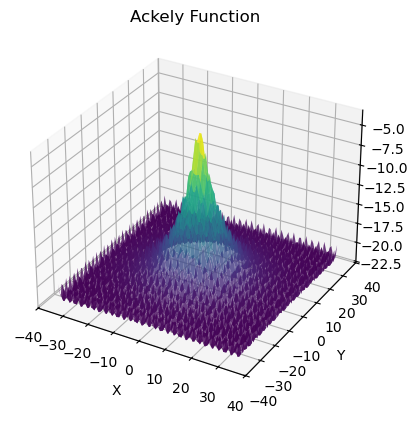

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-35, 35, 100)
y_range = np.linspace(-35, 35, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Ackely Function')

# Show the plot
plt.show()

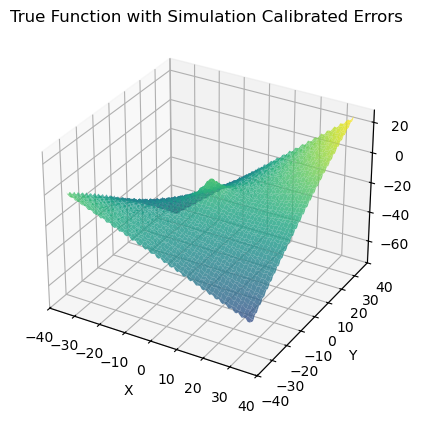

In [15]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [16]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [17]:
df_new = pd.DataFrame

In [18]:
obj_val_df = pd.DataFrame(columns=["Highest_Selected_Point", "Num_Points_In_df"])

In [19]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-35, 35, 100)
    x2_range = np.linspace(-35, 35, 100)
    bounds = np.array([[-35, 35], [-35, 35]])  # Bounds for x1 and x2

    # Create a meshgrid and combine into a single array
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

    # Calculate the Upper Confidence Level (UCL)
    ucl = pred_mean + 1.96 * pred_std

    # Locate the global maximum of the UCL
    max_index = np.argmax(ucl)
    global_max_point = x_grid[max_index]

    # Generate 9 additional points using Latin Hypercube Sampling (LHS) around the global maximum
    num_new_points = 9
    lhs_sampler = qmc.LatinHypercube(d=2)
    lhs_sample = lhs_sampler.random(num_new_points)

    # Scale LHS samples to a region around the global UCL maximum
    scaling_factor = 0.5  # Factor to control sampling range
    lhs_x1 = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) * (lhs_sample[:, 0] - 0.5)
    lhs_x2 = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) * (lhs_sample[:, 1] - 0.5)

    # Combine the LHS samples with the global maximum point
    new_points = np.c_[lhs_x1, lhs_x2]
    global_max_point = global_max_point.reshape(1, -1)  # Reshape to 2D for consistency
    all_points = np.vstack([new_points, global_max_point])  # Combine new points with the global max point

    # Clip the points to stay within the defined bounds
    all_points = np.clip(all_points, bounds[:, 0], bounds[:, 1])

    # Calculate UCL values for the newly sampled points
    new_mean, new_std = mc_dropout_predictions(best_model, all_points)
    new_ucl = new_mean + 1.96 * new_std  # Calculate the UCL for all sampled points

    # Store new sampled points and their UCL values in a DataFrame
    selected_points_df = pd.DataFrame(all_points, columns=['x', 'y'])
    df2 = selected_points_df.copy()
    selected_points_df['z'] = new_ucl

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(selected_points_df['x'], selected_points_df['y'], selected_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    from matplotlib.patches import Rectangle

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x1_grid, x2_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Ensure global_max_point is 1D
    global_max_point = global_max_point.ravel()  # Flatten to a 1D array

    # Bounding box calculations
    scaling_factor = 0.5  # Scaling factor used earlier
    x1_min = global_max_point[0] - scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x1_max = global_max_point[0] + scaling_factor * (x1_range.max() - x1_range.min()) / 2
    x2_min = global_max_point[1] - scaling_factor * (x2_range.max() - x2_range.min()) / 2
    x2_max = global_max_point[1] + scaling_factor * (x2_range.max() - x2_range.min()) / 2

    # Draw the bounding box
    bbox = Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min,
                    edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
    plt.gca().add_patch(bbox)

    # Optionally overlay sampled points
    plt.scatter(all_points[:, 0], all_points[:, 1], color='white', edgecolor='black', label='Sampled Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response with Bounding Box")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    global obj_val_df
    # Append to tracking DataFrame
    new_entry = pd.DataFrame({
        "Highest_Selected_Point": [df2['sim_z'].max()],
        "Num_Points_In_df": [len(df)]
    })
    obj_val_df = pd.concat([obj_val_df, new_entry], ignore_index=True)

    return df, df2


Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 1e-05
dropout_rate: 0.5
batch_size: 150
epochs: 70
Epoch 1/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 626.1534
Epoch 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 621.8538
Epoch 3/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 618.9908
Epoch 4/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 626.4836
Epoch 5/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 627.4644
Epoch 6/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 622.8526
Epoch 7/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 628.4571
Epoch 8/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 624.8934
Epoch 9/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 627.4095
Epoch 10/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 624.6648
Epoch 11/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 622.7250
Epoch 12/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 622.7032
Epoch 13/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 620.8481
Epoch 14/70
1/1 ━━━━━━━━

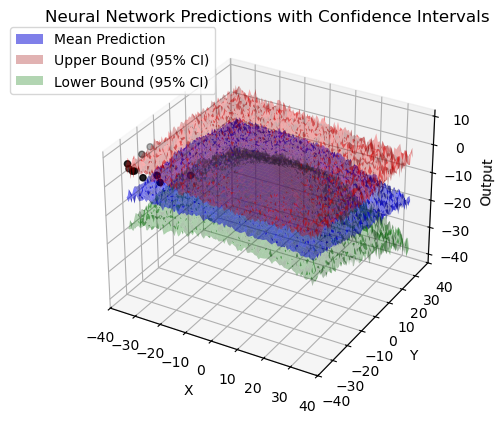

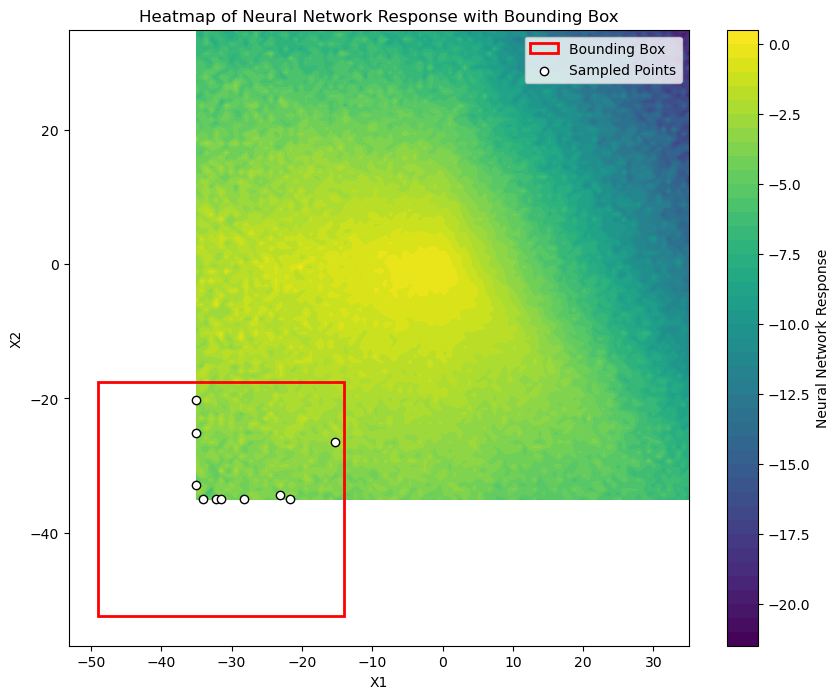

           x          y          z         a         b     sim_z       diff
0 -34.078994 -35.000000 -20.179400  7.593091 -3.055364  0.014069 -20.193469
3 -35.000000 -32.964329 -19.973891  7.593091 -3.055364 -0.976596 -18.997295
4 -32.209785 -35.000000 -20.838053  7.593091 -3.055364 -1.963880 -18.874174
9 -31.464646 -35.000000 -21.730258  7.593091 -3.055364 -3.332661 -18.397598
7 -28.213048 -35.000000 -20.800471  7.593091 -3.055364 -4.732185 -16.068286
            x          y          z         a         b      sim_z       diff
0   -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1   15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2  -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3  -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4  -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522
5  -34.078994 -35.000000 -20.179400  7.593091 -3.055364   0.014069 -20.19346

In [20]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 4.703614341974578e-05
dropout_rate: 0.5
batch_size: 150
epochs: 50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 256.8887
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 259.4247
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 259.9409
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 261.0050
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 260.7130
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 260.3482
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 258.1321
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 261.7574
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 263.6868
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 261.4161
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 263.4377
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 258.7361
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 260.4243
Epoch 14

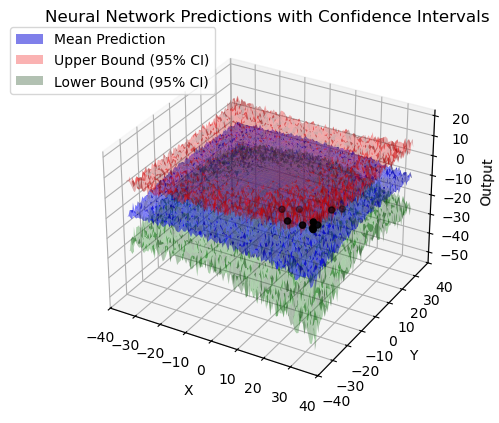

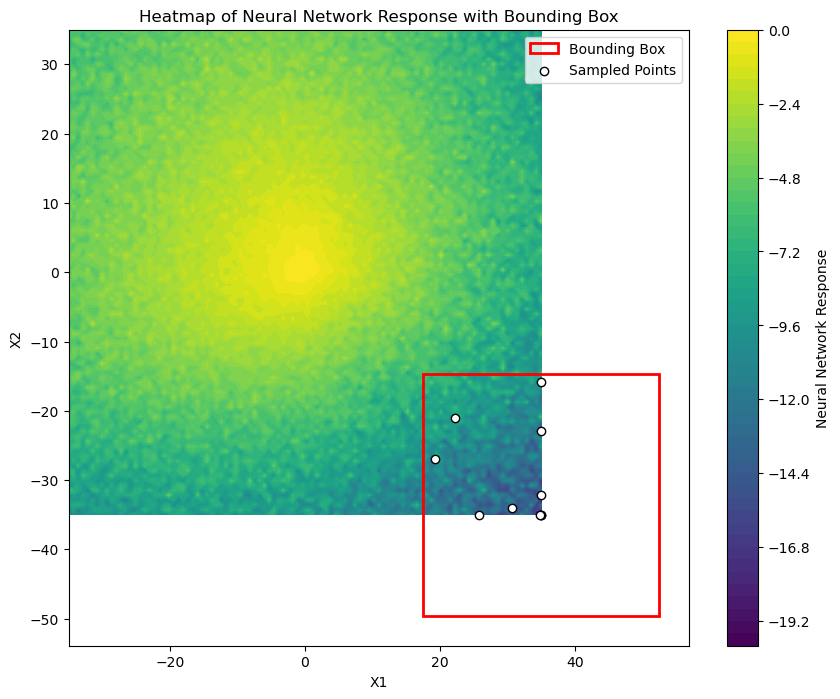

In [21]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 103
learning_rate: 0.0003111417597748773
dropout_rate: 0.40419965934322194
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 806.0663
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 776.0363 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 759.2804 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 786.2231 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 807.1374 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 782.2089 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 803.3510 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 806.0095 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 795.6489 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 780.2224 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 768.7471 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 792.0589 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

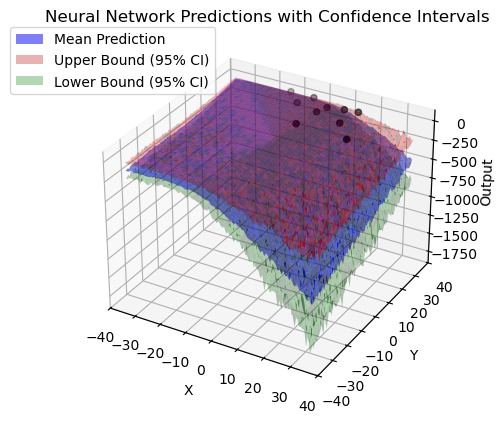

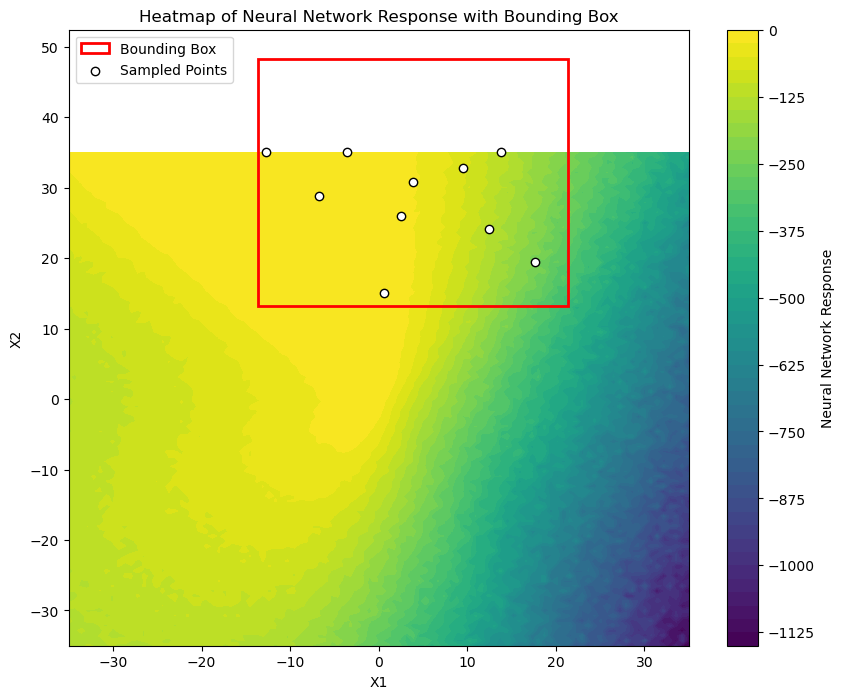

In [22]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 4
num_units: 200
learning_rate: 0.002038764244825779
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 725.8646
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 717.5363
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 708.6074
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 696.8112
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 680.9221
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 659.7480
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 631.8655
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 595.6984
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 550.1531
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 494.7628
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 430.7207
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 362.4253
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 299

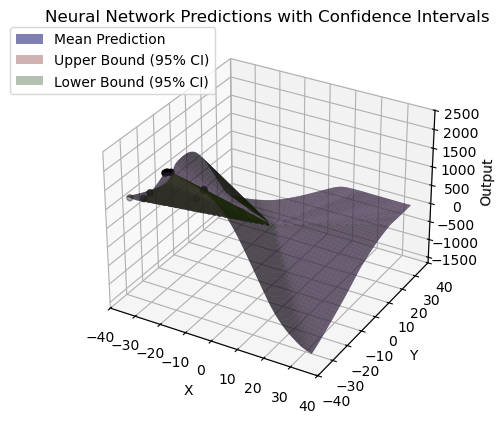

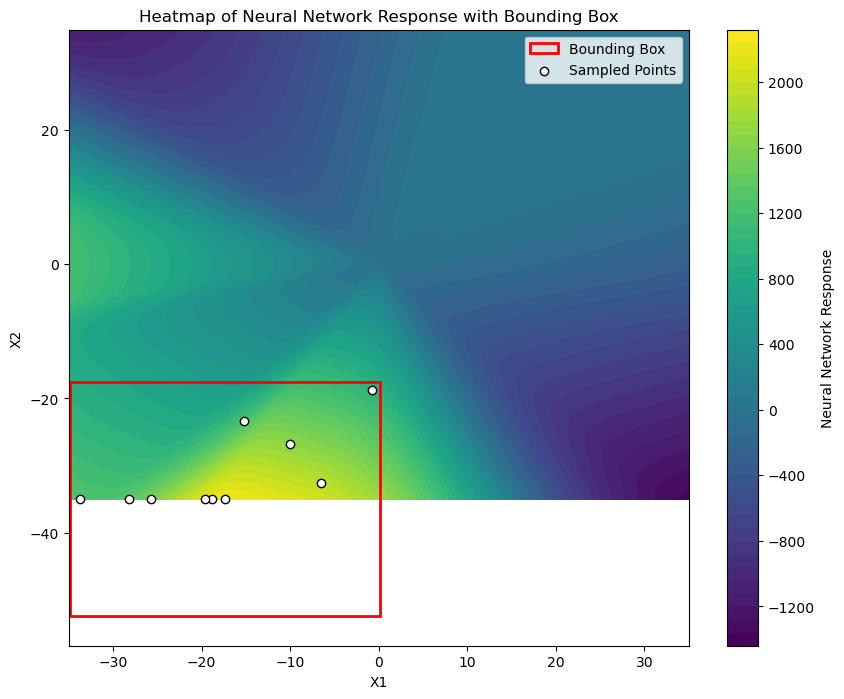

In [23]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.03606912878263642
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 850.9952
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 528.1855 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 595.0408 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 475.5193 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 451.4844 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 506.0893 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 560.4952 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 616.6802 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 571.1257 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 592.3843 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 503.2914 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 511.9815 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 444.4

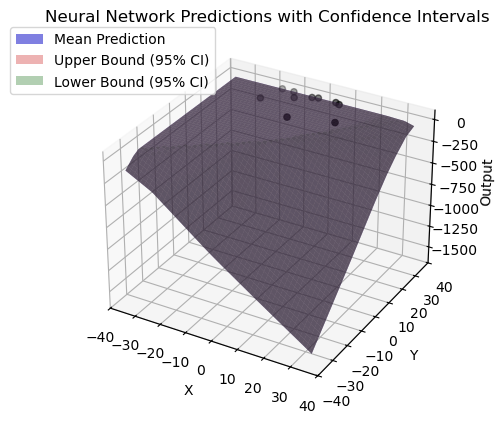

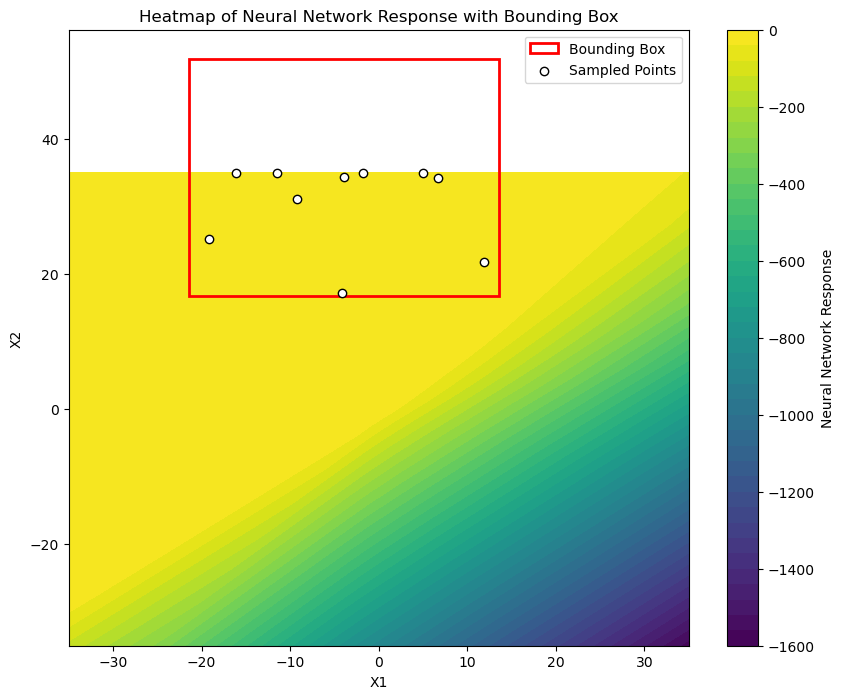

In [24]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 3
num_units: 200
learning_rate: 0.02329655230099585
dropout_rate: 0.5
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 675.5231
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 469.8771
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 274.3089
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 204.5586
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 196.4567
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 213.5216
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 166.4642
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 185.3843
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 183.7547
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 179.4770
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 205.8526
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 183.4571
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 156.

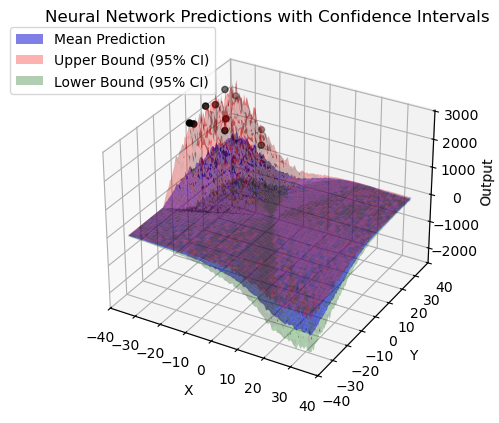

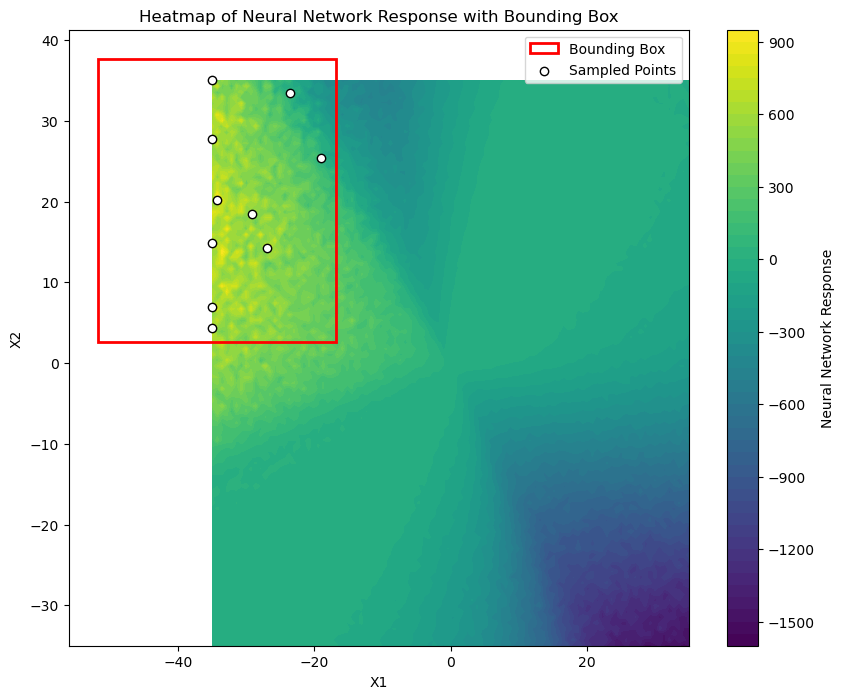

           x          y          z         a         b      sim_z       diff
8 -35.000000   4.362242 -21.356750  7.593091 -3.055364 -38.610353  17.253603
1 -35.000000   6.958731 -19.857047  7.593091 -3.055364 -39.944884  20.087837
6 -27.022228  14.302725 -21.083240  7.593091 -3.055364 -42.941110  21.857870
2 -19.010169  25.412712 -21.350317  7.593091 -3.055364 -44.541616  23.191299
7 -35.000000  14.852657 -20.494177  7.593091 -3.055364 -49.192645  28.698468
            x          y          z         a         b      sim_z       diff
0   -5.808460 -28.536298 -21.648132  7.593091 -3.055364  42.723724 -64.371856
1   15.422715 -21.961785 -21.250438  7.593091 -3.055364 -14.618943  -6.631496
2  -34.991994 -10.810749 -20.641314  7.593091 -3.055364  32.609511 -53.250825
3  -13.836720  -7.226277 -19.245342  7.593091 -3.055364   0.832579 -20.077920
4  -24.727088   2.717171 -21.194934  7.593091 -3.055364   1.331588 -22.526522
..        ...        ...        ...       ...       ...        ...    

In [25]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 8
num_units: 177
learning_rate: 0.013816419477399894
dropout_rate: 0.214649661012278
batch_size: 133
epochs: 144
Epoch 1/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1005.3126
Epoch 2/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 553.9126
Epoch 3/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 113573.8047
Epoch 4/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 359.0959
Epoch 5/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 948.7385
Epoch 6/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 996.3645
Epoch 7/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1002.1976
Epoch 8/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1003.1424
Epoch 9/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1003.3542
Epoch 10/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1003.5016
Epoch 11/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1003.5505
Epoch 12/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1003.4263
Epoch 13/144
1/1 ━━━━━━━━━━━━━━━━━━━━ 

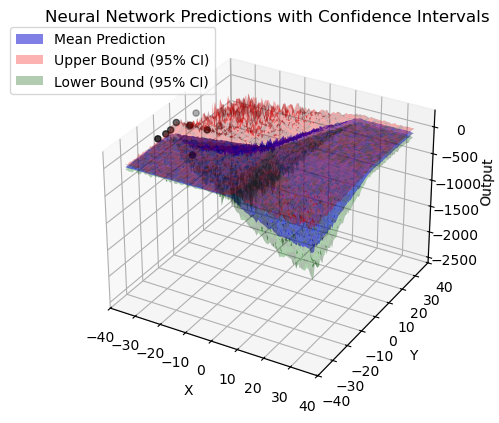

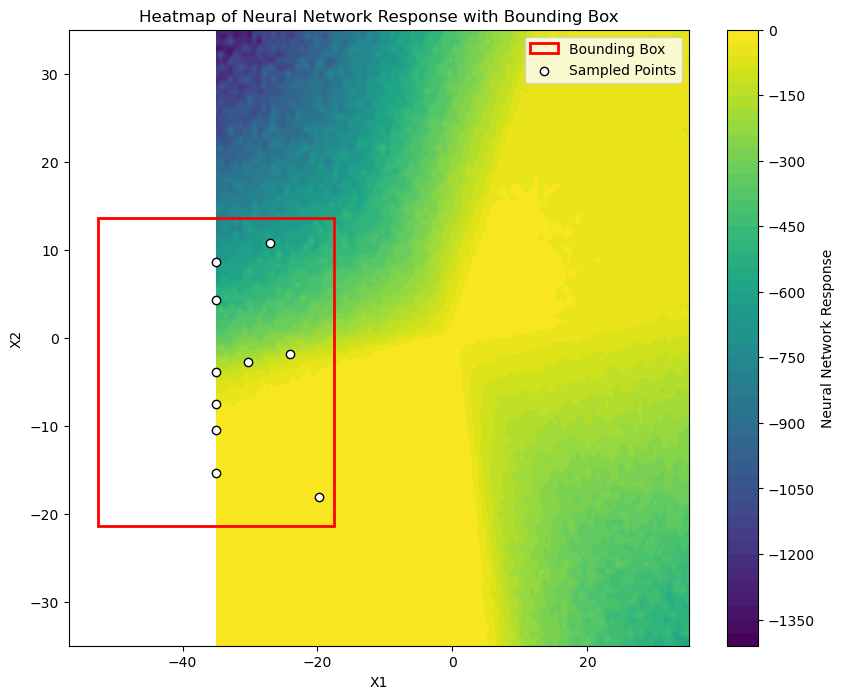

           x          y          z         a         b      sim_z      diff
3 -19.734636 -18.142671 -20.988303  7.593091 -3.055364 -18.223414 -2.764889
6 -35.000000 -15.360000 -21.381991  7.593091 -3.055364 -18.528462 -2.853530
7 -35.000000 -10.505154 -21.626860  7.593091 -3.055364 -23.452856  1.825996
4 -35.000000  -7.481565 -21.445931  7.593091 -3.055364 -26.461204  5.015273
1 -24.118196  -1.803199 -20.305067  7.593091 -3.055364 -27.729351  7.424284


In [26]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0008699630913338759
dropout_rate: 0.0
batch_size: 150
epochs: 163
Epoch 1/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1003.9034
Epoch 2/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1002.3569
Epoch 3/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1000.8409
Epoch 4/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 998.4579
Epoch 5/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 994.6508
Epoch 6/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 988.5028
Epoch 7/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 978.5703
Epoch 8/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 962.7326
Epoch 9/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 937.9163
Epoch 10/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 899.3013
Epoch 11/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 840.6070
Epoch 12/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 754.4639
Epoch 13/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss

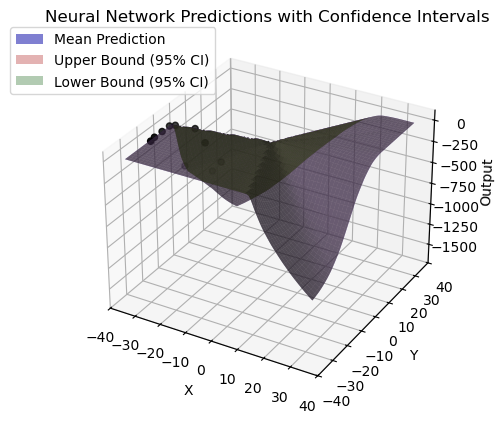

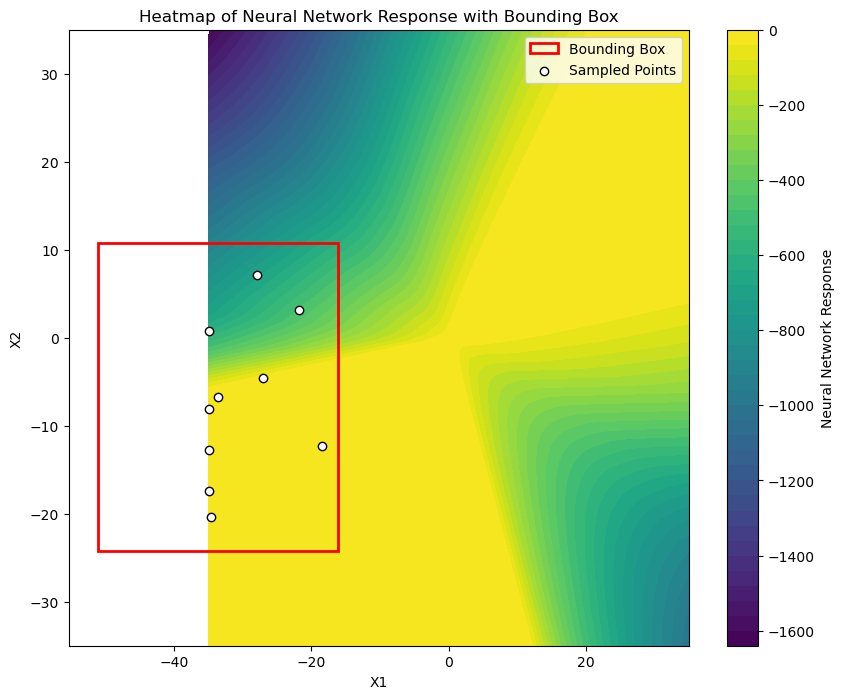

In [27]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.03145472060657774
dropout_rate: 0.0
batch_size: 150
epochs: 50
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step - loss: 949.2564
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 888.6852
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 812.7391
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 706.5909
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 572.5362
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 427.8106
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 308.9347
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 266.2454
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 293.5611
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 313.1692
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 280.6039
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 221.5241
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 173.9366
Epoch 1

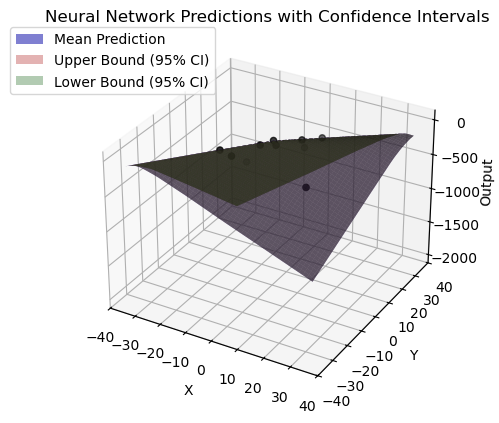

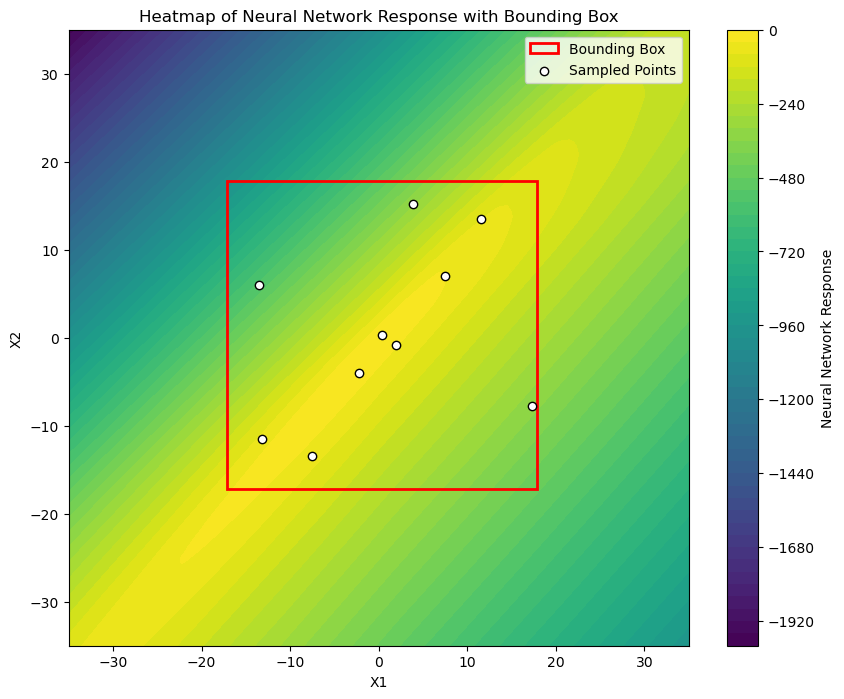

In [28]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 50
learning_rate: 0.0031142657170997088
dropout_rate: 0.0
batch_size: 20
epochs: 162
Epoch 1/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 942.6334
Epoch 2/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 909.6810  
Epoch 3/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 648.0707 
Epoch 4/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 469.0594 
Epoch 5/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 363.8878 
Epoch 6/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 235.3626 
Epoch 7/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148.7224
Epoch 8/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 209.6979 
Epoch 9/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 210.6891 
Epoch 10/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150.7002 
Epoch 11/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129.8358 
Epoch 12/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.3118 
Epoch 13/162
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135.

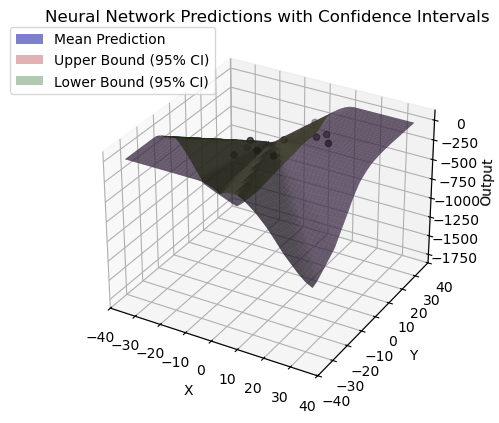

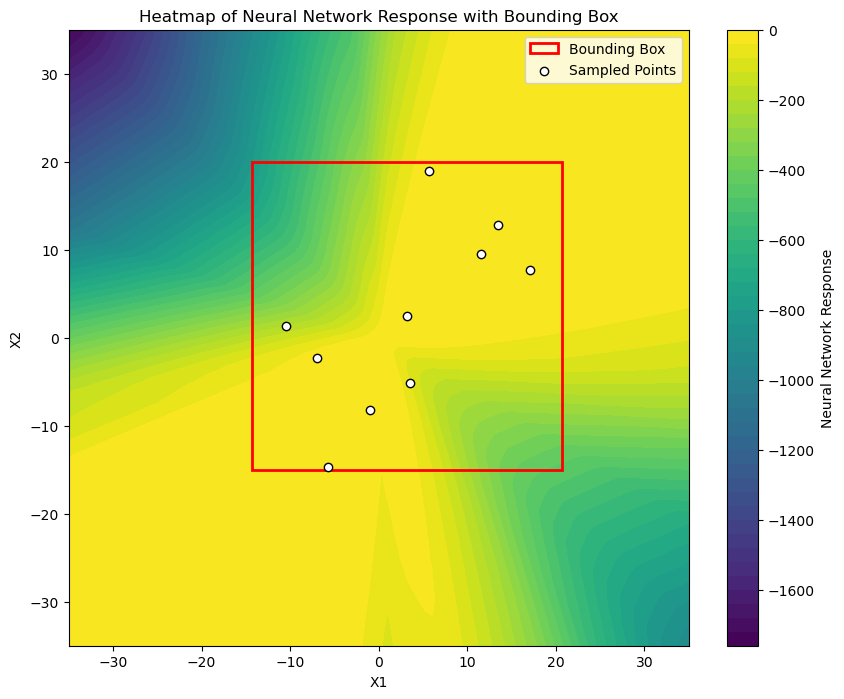

In [29]:
df_sim, df_new = perform_iteration(df_sim, df)

In [ ]:
df_sim, df_new = perform_iteration(df_sim, df)

In [1]:
obj_val_df

NameError: name 'obj_val_df' is not defined

In [55]:
df_new

x          y          z         a         b      sim_z       diff
0  35.000000 -17.440919 -21.693866  3.796938 -3.103384 -42.198290  20.504424
7  35.000000 -21.675900 -21.364600  3.796938 -3.103384 -47.238838  25.874238
3  19.160702 -35.000000 -20.519769  3.796938 -3.103384 -47.334156  26.814387
1  22.206712 -35.000000 -20.719403  3.796938 -3.103384 -50.873766  30.154362
8  35.000000 -25.415123 -21.569811  3.796938 -3.103384 -52.335692  30.765881

In [56]:
df

x          y          z         a         b       sim_z        diff
0  17.938948  17.524605 -21.162297  3.796938 -3.103384  152.909133 -174.071429
1  10.766910  17.900720 -20.119736  3.796938 -3.103384  154.595987 -174.715723
2 -18.231554 -27.602654 -21.842488  3.796938 -3.103384  378.983802 -400.826290
3  34.386019  -0.431637 -22.250567  3.796938 -3.103384   -9.999305  -12.251263
4  13.619679 -32.066740 -21.387510  3.796938 -3.103384  499.850184 -521.237694

In [57]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -256.62047966059424


In [58]:
df = pd.concat([df, df_new], ignore_index=True)
df

x          y          z         a         b       sim_z        diff
0  17.938948  17.524605 -21.162297  3.796938 -3.103384  152.909133 -174.071429
1  10.766910  17.900720 -20.119736  3.796938 -3.103384  154.595987 -174.715723
2 -18.231554 -27.602654 -21.842488  3.796938 -3.103384  378.983802 -400.826290
3  34.386019  -0.431637 -22.250567  3.796938 -3.103384   -9.999305  -12.251263
4  13.619679 -32.066740 -21.387510  3.796938 -3.103384  499.850184 -521.237694
5  35.000000 -17.440919 -21.693866  3.796938 -3.103384  -42.198290   20.504424
6  35.000000 -21.675900 -21.364600  3.796938 -3.103384  -47.238838   25.874238
7  19.160702 -35.000000 -20.519769  3.796938 -3.103384  -47.334156   26.814387
8  22.206712 -35.000000 -20.719403  3.796938 -3.103384  -50.873766   30.154362
9  35.000000 -25.415123 -21.569811  3.796938 -3.103384  -52.335692   30.765881

In [59]:
df = df.iloc[:, :-4]
df

x          y          z
0  17.938948  17.524605 -21.162297
1  10.766910  17.900720 -20.119736
2 -18.231554 -27.602654 -21.842488
3  34.386019  -0.431637 -22.250567
4  13.619679 -32.066740 -21.387510
5  35.000000 -17.440919 -21.693866
6  35.000000 -21.675900 -21.364600
7  19.160702 -35.000000 -20.519769
8  22.206712 -35.000000 -20.719403
9  35.000000 -25.415123 -21.569811

In [ ]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)



[ 7.45820391 -2.93194268]


In [61]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": -0.025, "Y":  -0.025, "Z": benchmark( -0.025,  -0.025)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

X      Y         Z
0 -0.025 -0.025 -0.133012

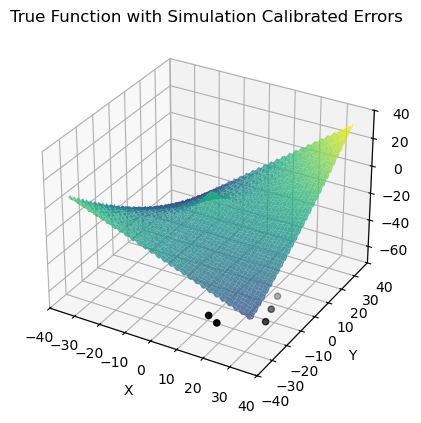

In [ ]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)



# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [63]:
df

x          y          z         a         b       sim_z        diff
0  17.938948  17.524605 -21.162297  7.458204 -2.931943   65.612181  -86.774478
1  10.766910  17.900720 -20.119736  7.458204 -2.931943   74.791559  -94.911295
2 -18.231554 -27.602654 -21.842488  7.458204 -2.931943  251.378820 -273.221307
3  34.386019  -0.431637 -22.250567  7.458204 -2.931943  -58.794037   36.543470
4  13.619679 -32.066740 -21.387510  7.458204 -2.931943  273.379324 -294.766834
5  35.000000 -17.440919 -21.693866  7.458204 -2.931943   18.500940  -40.194806
6  35.000000 -21.675900 -21.364600  7.458204 -2.931943   66.241616  -87.606216
7  19.160702 -35.000000 -20.519769  7.458204 -2.931943  323.154581 -343.674350
8  22.206712 -35.000000 -20.719403  7.458204 -2.931943  316.460087 -337.179490
9  35.000000 -25.415123 -21.569811  7.458204 -2.931943  117.247484 -138.817296

In [64]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -166.06026021773408


In [65]:
# New DataFrame with the first 5 data points
df_original = df.iloc[:5]

print(df_original)

           x          y          z         a         b       sim_z        diff
0  17.938948  17.524605 -21.162297  7.458204 -2.931943   65.612181  -86.774478
1  10.766910  17.900720 -20.119736  7.458204 -2.931943   74.791559  -94.911295
2 -18.231554 -27.602654 -21.842488  7.458204 -2.931943  251.378820 -273.221307
3  34.386019  -0.431637 -22.250567  7.458204 -2.931943  -58.794037   36.543470
4  13.619679 -32.066740 -21.387510  7.458204 -2.931943  273.379324 -294.766834


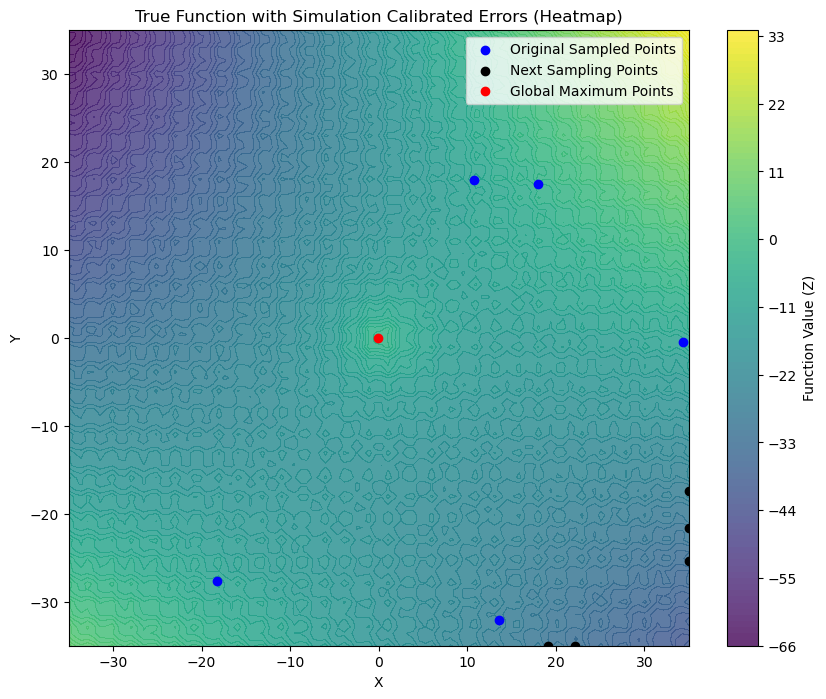

In [ ]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [67]:
df_new2 = pd.DataFrame

df_sim = df.copy()

Best hyperparameters:
num_layers: 8
num_units: 137
learning_rate: 0.0014108892283675816
dropout_rate: 0.3793078121611787
batch_size: 34
epochs: 121
Epoch 1/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 37440.7930
Epoch 2/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 37411.9375
Epoch 3/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 37399.5078
Epoch 4/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 37367.8867
Epoch 5/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 37366.3945
Epoch 6/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 37311.2070
Epoch 7/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 37283.6445
Epoch 8/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 37156.8633
Epoch 9/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 37054.8477
Epoch 10/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 36879.9180
Epoch 11/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 36678.9102
Epoch 12/121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 36149.3711
Epoch 13/121
1/1 ━━━━━━

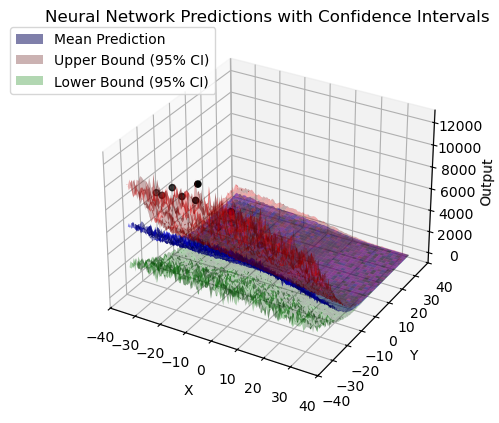

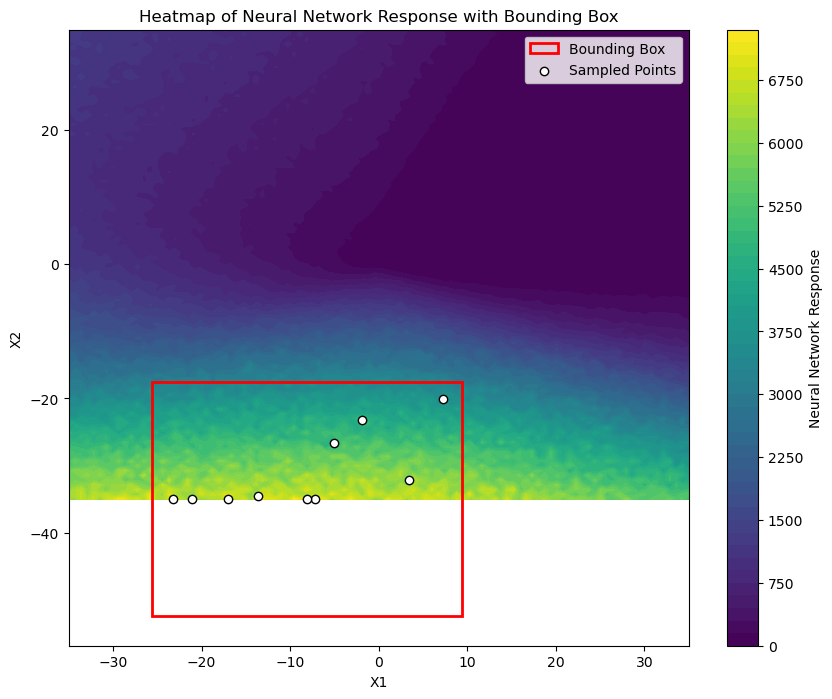

In [ ]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 162
learning_rate: 0.0007350446112476766
dropout_rate: 0.3384537308200681
batch_size: 70
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 18815.4980
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18802.4141
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 18793.2461
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 18775.6094
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18776.2539
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18759.6973
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 18759.0469
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18742.8340
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18743.2383
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18715.5156
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 18696.7051
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 18682.9062
Epoch 13/200
1/1 ━━━━━━

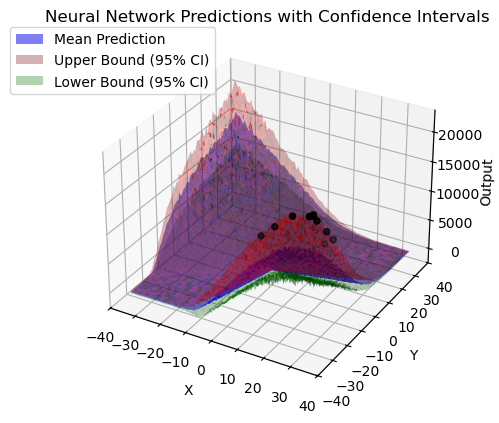

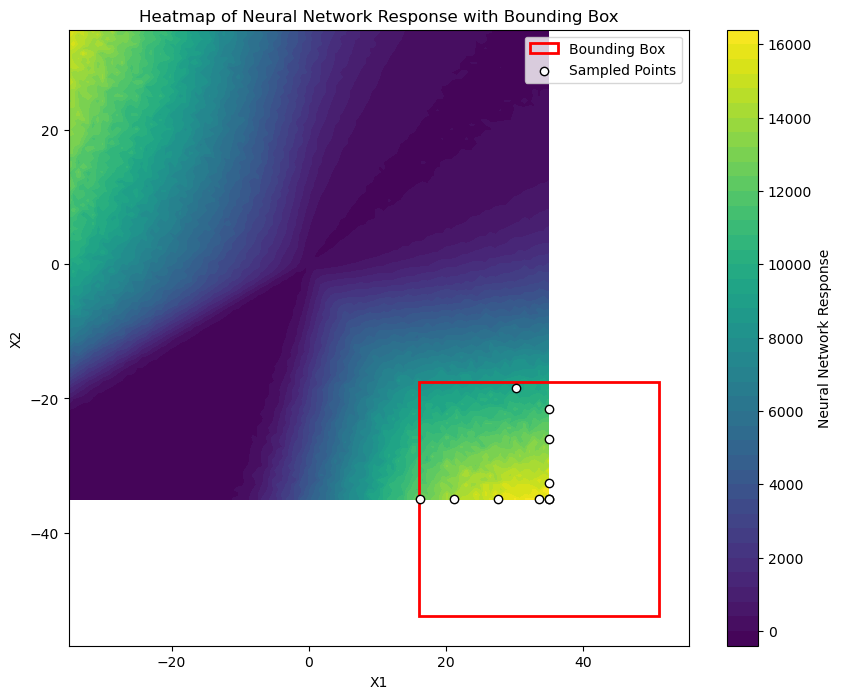

In [ ]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [ ]:
df_sim, df_new2 = perform_iteration(df_sim, df)

KeyboardInterrupt: 

Best hyperparameters:
num_layers: 8
num_units: 188
learning_rate: 0.0011756282070800373
dropout_rate: 0.2558774793979888
batch_size: 43
epochs: 153
Epoch 1/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1775.8953
Epoch 2/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1774.1877
Epoch 3/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1770.5494
Epoch 4/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1764.2317
Epoch 5/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1755.5863
Epoch 6/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1741.9856
Epoch 7/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1718.3386
Epoch 8/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1698.1791
Epoch 9/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1626.8801
Epoch 10/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1575.0958
Epoch 11/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1534.6083
Epoch 12/153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1534.3031
Epoch 13/153
1/1 ━━━━━━━━━━━━━━━━━━

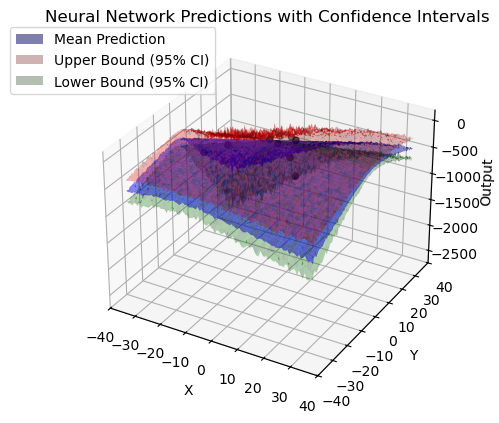

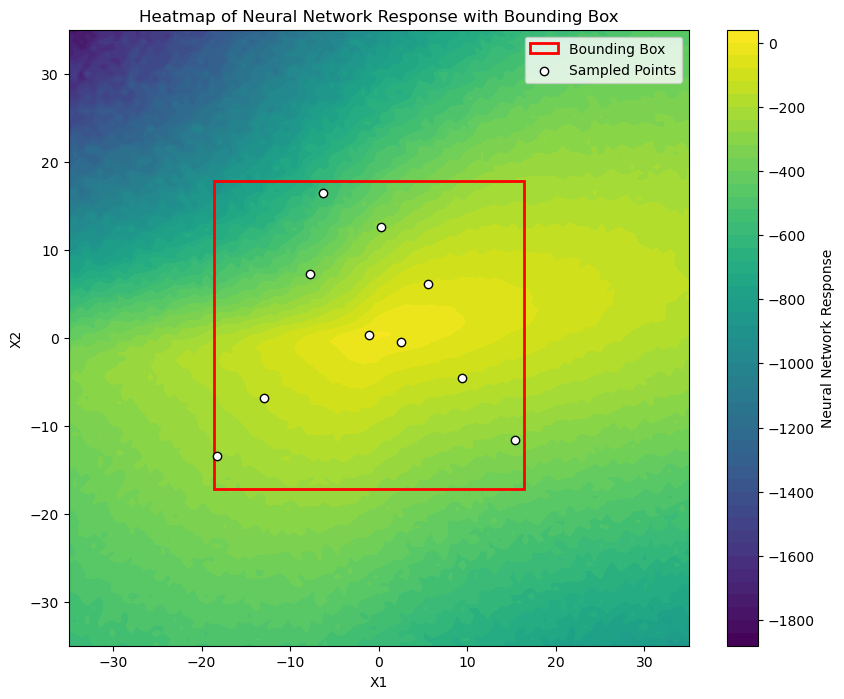

In [103]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 7
num_units: 200
learning_rate: 0.002127459439380763
dropout_rate: 0.35975665982909943
batch_size: 145
epochs: 88
Epoch 1/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1496.7007
Epoch 2/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1492.4194
Epoch 3/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1487.7473
Epoch 4/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1475.6921
Epoch 5/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1452.1678
Epoch 6/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1421.9442
Epoch 7/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1363.0142
Epoch 8/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1273.7080
Epoch 9/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1262.2196
Epoch 10/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1263.5988
Epoch 11/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1274.9901
Epoch 12/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1232.5935
Epoch 13/88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

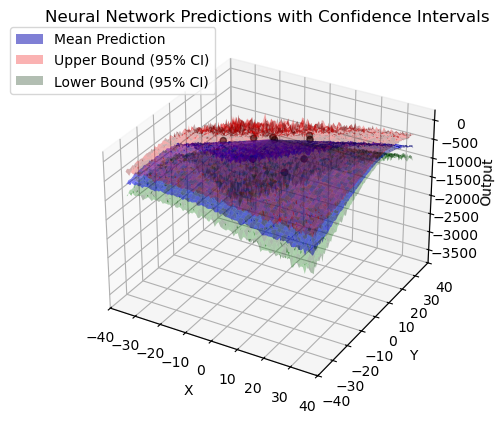

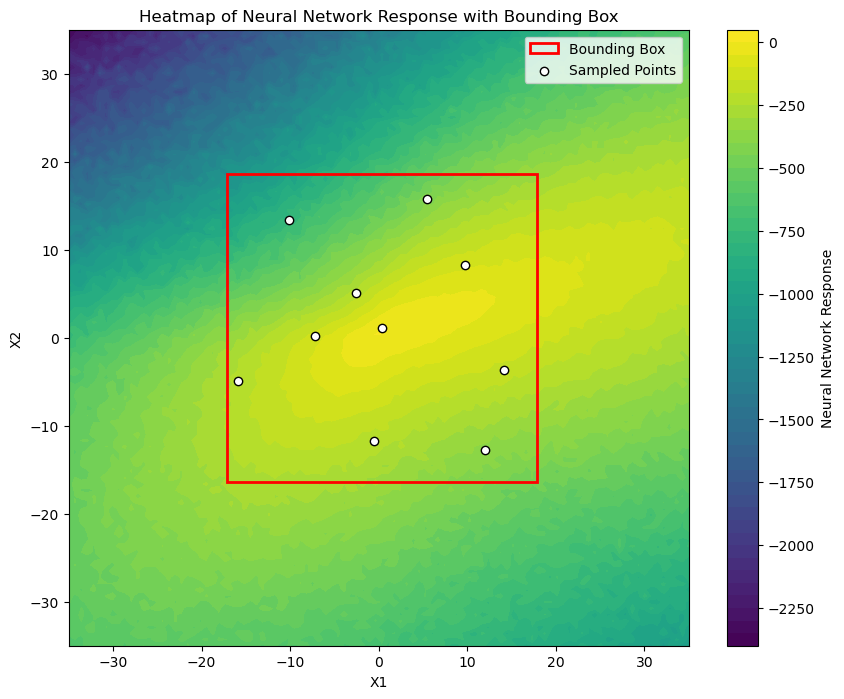

In [104]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 8
num_units: 113
learning_rate: 0.0016774857410477234
dropout_rate: 0.12183292882148969
batch_size: 81
epochs: 112
Epoch 1/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1305.3032
Epoch 2/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1303.3003
Epoch 3/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1300.4738
Epoch 4/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1295.0715
Epoch 5/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1286.0093
Epoch 6/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1273.0836
Epoch 7/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1252.8503
Epoch 8/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1223.4102
Epoch 9/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1180.1389
Epoch 10/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1130.0618
Epoch 11/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1077.2655
Epoch 12/112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1064.6096
Epoch 13/112
1/1 ━━━━━━━━━━━━━━━━━

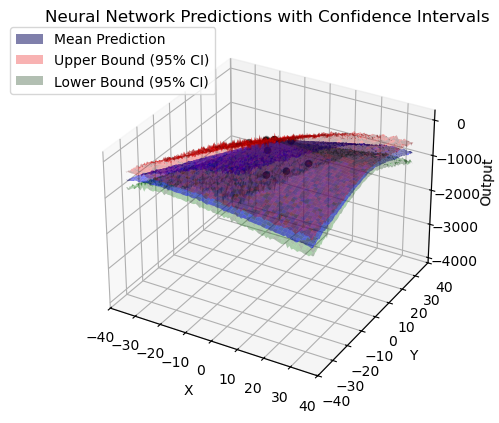

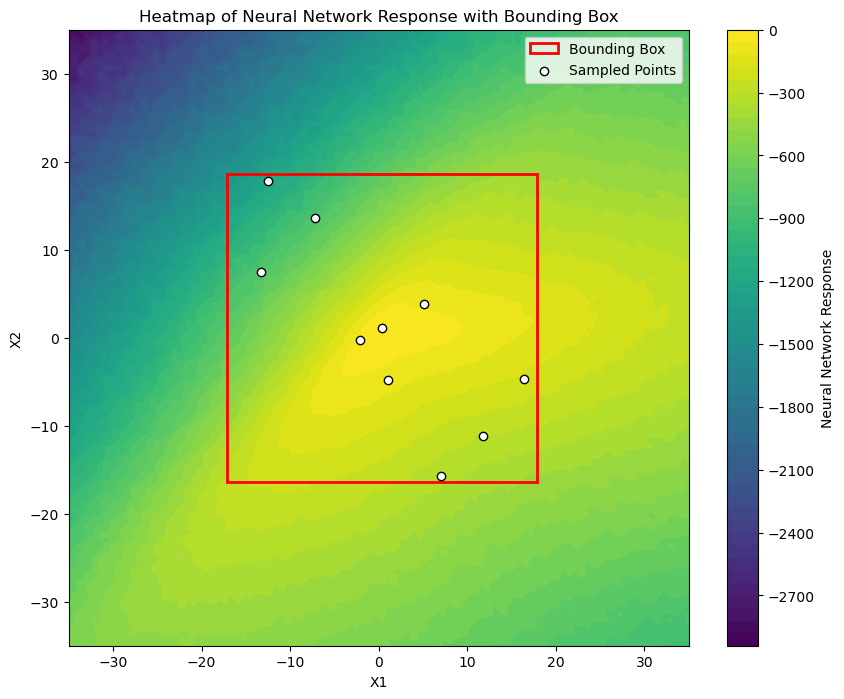

In [105]:
df_sim, df_new2 = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 6
num_units: 94
learning_rate: 0.0014164288244163672
dropout_rate: 0.10183285011643646
batch_size: 39
epochs: 187
Epoch 1/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1000.9672
Epoch 2/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1215.2811 
Epoch 3/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1050.6348
Epoch 4/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1322.1792 
Epoch 5/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1054.6564
Epoch 6/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1310.7163 
Epoch 7/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1238.3082 
Epoch 8/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 908.8893 
Epoch 9/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1200.0381 
Epoch 10/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1029.8772 
Epoch 11/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1099.7334 
Epoch 12/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 894.6170 
Epoch 13/187
2/2 ━━━━━━━━━━━━━━━━━━━━ 

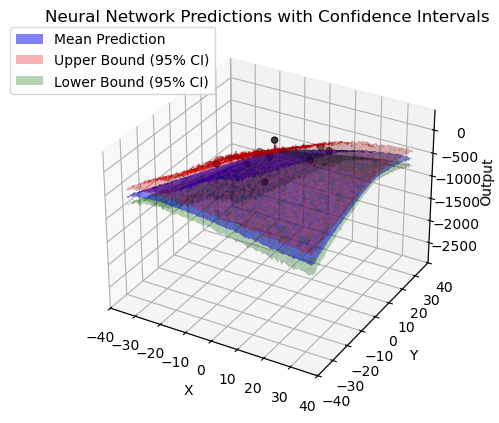

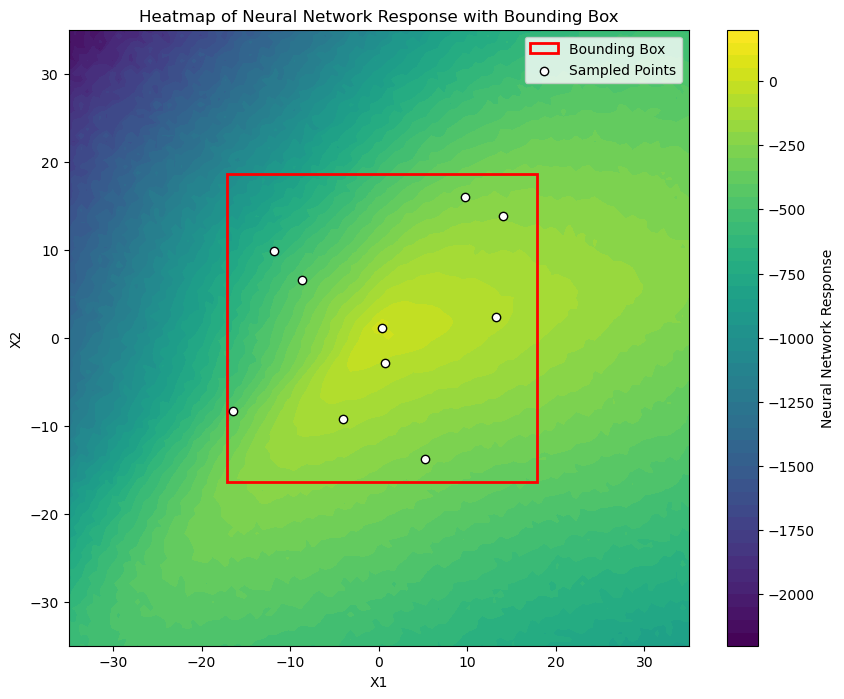

In [106]:
df_sim, df_new2 = perform_iteration(df_sim, df)

In [107]:
df_new2

x          y          z         a         b      sim_z      diff
9   0.353535   1.060606  -4.528937  4.558513 -3.308432  -4.423915 -0.105022
7   0.749010  -2.845675  -8.180547  4.558513 -3.308432  -8.320484  0.139937
3  14.004272  13.825317 -19.422100  4.558513 -3.308432 -15.737644 -3.684457
0  -4.040295  -9.269090 -16.430419  4.558513 -3.308432 -16.800240  0.369821
5  13.274854   2.299277 -18.989695  4.558513 -3.308432 -17.342310 -1.647385

In [108]:
df

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674
5  -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   -0.510053
6   3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886    2.631546
7  -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408  -16.335296
8   7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839  -21.398110
9  17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678    7.321368

In [109]:
df = pd.concat([df, df_new2], ignore_index=True)
df

x          y          z         a         b       sim_z  \
0   23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939   
1   31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804   
2   -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515   
3    9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668   
4    5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395   
5   -0.353535  -0.353535  -3.651918  4.558513 -3.308432   -3.141865   
6    3.848584  -0.984131  -9.145339  4.558513 -3.308432  -11.776886   
7   -1.455913   5.240717 -12.707889  4.558513 -3.308432    3.627408   
8    7.210342  -7.168751 -16.383271  4.558513 -3.308432    5.014839   
9   17.057663  -3.899303 -18.589309  4.558513 -3.308432  -25.910678   
10   0.353535   1.060606  -4.528937  4.558513 -3.308432   -4.423915   
11   0.749010  -2.845675  -8.180547  4.558513 -3.308432   -8.320484   
12  14.004272  13.825317 -19.422100  4.558513 -3.308432  -15.737644   
13  -4.040295  -9.269090 -16.430419  4.558513 -3.308432  -16.800240   
14  13.274854   2.299277 -18.989695  4.558513 -3.308432  -17.342310   

          diff  
0   -65.051846  
1     4.010469  
2   -91.728325  
3  -190.529543  
4  -133.338674  
5    -0.510053  
6     2.631546  
7   -16.335296  
8   -21.398110  
9     7.321368  
10   -0.105022  
11    0.139937  
12   -3.684457  
13    0.369821  
14   -1.647385

In [110]:
df = df.iloc[:, :-4]
df

x          y          z
0   23.543825  11.618400 -21.792907
1   31.442859  -7.073008 -21.554335
2   -4.794645  12.618852 -18.978809
3    9.034730  18.506400 -20.764875
4    5.999539  15.517246 -19.723279
5   -0.353535  -0.353535  -3.651918
6    3.848584  -0.984131  -9.145339
7   -1.455913   5.240717 -12.707889
8    7.210342  -7.168751 -16.383271
9   17.057663  -3.899303 -18.589309
10   0.353535   1.060606  -4.528937
11   0.749010  -2.845675  -8.180547
12  14.004272  13.825317 -19.422100
13  -4.040295  -9.269090 -16.430419
14  13.274854   2.299277 -18.989695

In [111]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.51043824 -3.31352674]


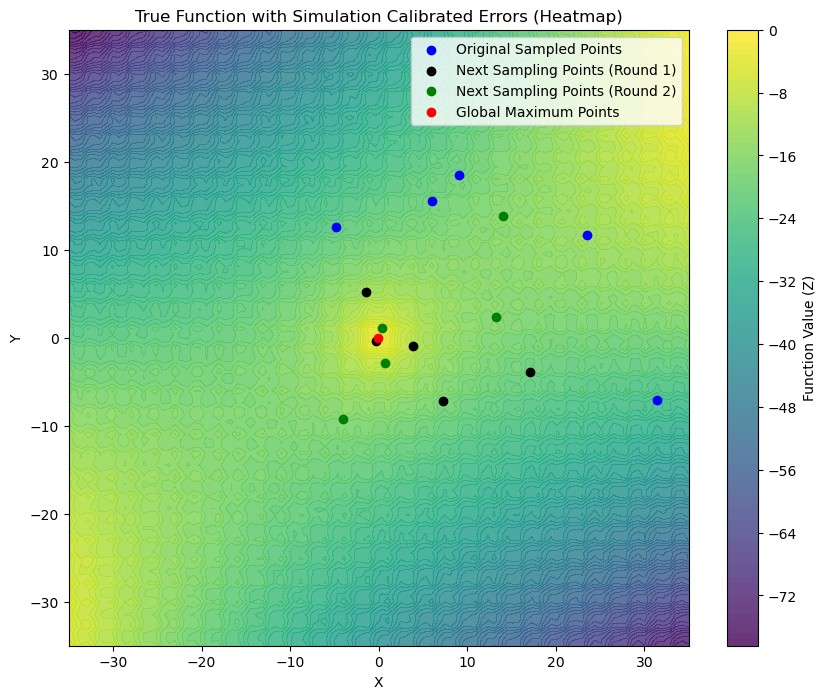

In [112]:
# Create the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the heatmap for sim_z_grid
heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

# Overlay scatter points for sampling points
ax.scatter(df_original["x"], df_original["y"], color='blue', marker='o', label='Original Sampled Points')
ax.scatter(df_new["x"], df_new["y"], color='black', marker='o', label='Next Sampling Points (Round 1)')
ax.scatter(df_new2["x"], df_new2["y"], color='green', marker='o', label='Next Sampling Points (Round 2)')

# Overlay scatter points for global maxima
ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Points')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
ax.legend()

# Add a color bar
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Function Value (Z)')

# Show the plot
plt.show()

In [113]:
df_original

x          y          z         a         b       sim_z        diff
0  23.543825  11.618400 -21.792907  4.558513 -3.308432   43.258939  -65.051846
1  31.442859  -7.073008 -21.554335  4.558513 -3.308432  -25.564804    4.010469
2  -4.794645  12.618852 -18.978809  4.558513 -3.308432   72.749515  -91.728325
3   9.034730  18.506400 -20.764875  4.558513 -3.308432  169.764668 -190.529543
4   5.999539  15.517246 -19.723279  4.558513 -3.308432  113.615395 -133.338674

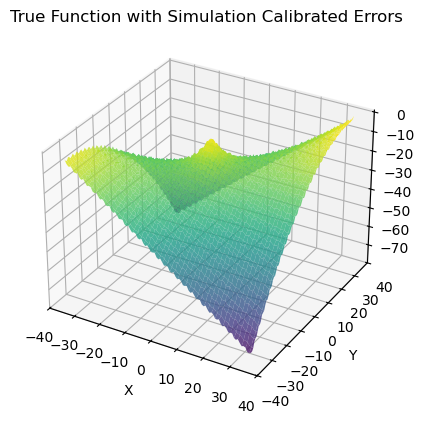

In [114]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()